Sod Shock Tube Problem
Domain: x ∈ [0, 1.0]
Grid points: 400
Gamma: 1.4
Initial conditions:
  Left state (x < 0.5): ρL = 1.0, uL = 0.0, pL = 1.0
  Right state (x ≥ 0.5): ρR = 0.125, uR = 0.0, pR = 0.1
Saving at t = 0.04 (actual t = 0.04000)
Saving at t = 0.08 (actual t = 0.08000)
Saving at t = 0.12 (actual t = 0.12000)
Saving at t = 0.16 (actual t = 0.16000)
Saving at t = 0.20 (actual t = 0.20000)


<ipython-input-1-6df04692ae91>:150: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis')


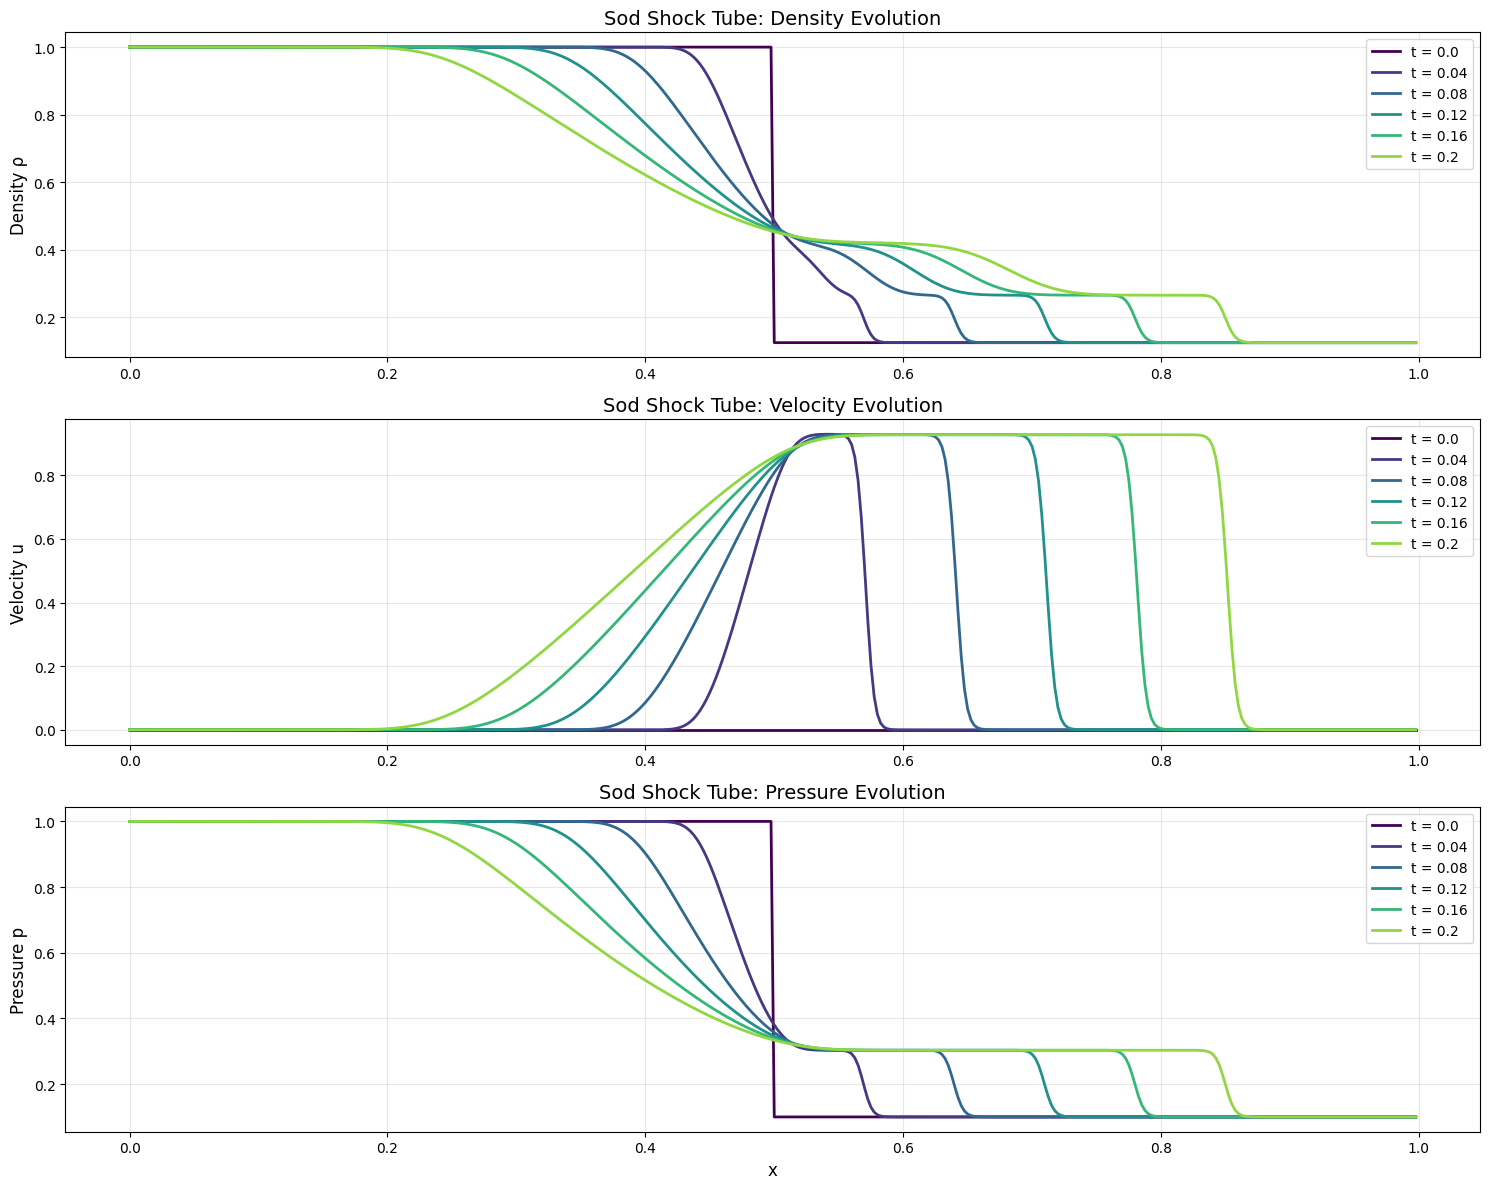

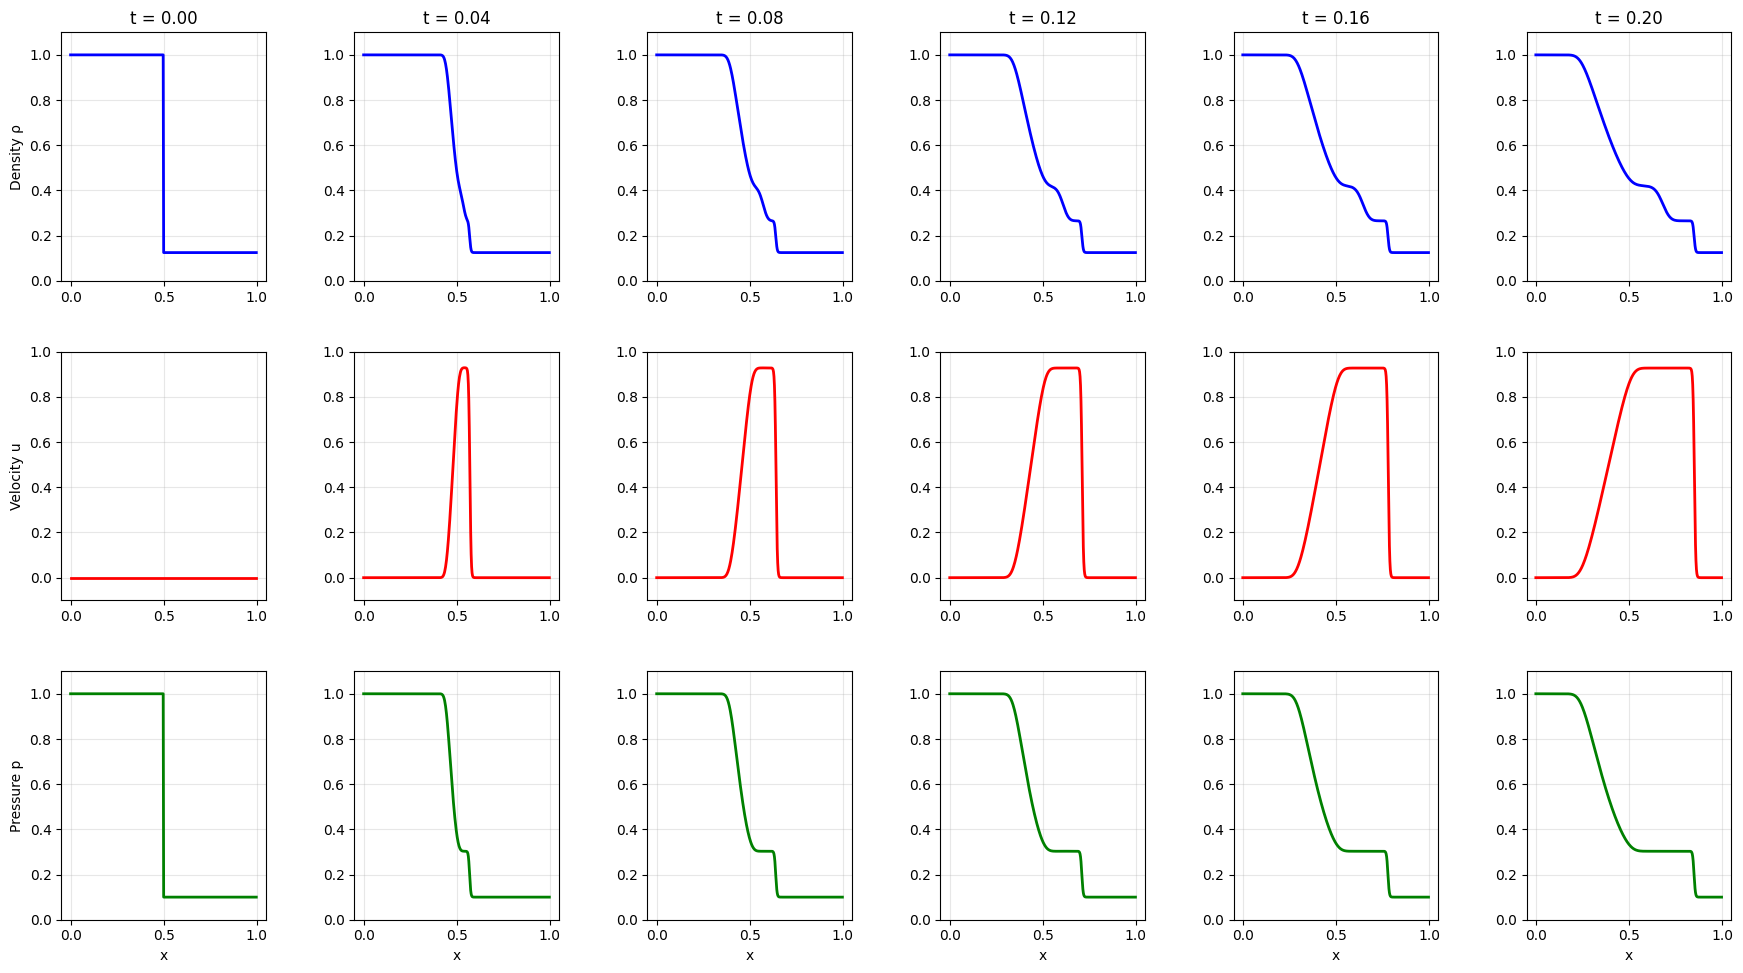

Simulation and visualization complete!


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

# Parameters
nx = 400       # Number of grid points
L = 1.0        # Domain length [0,L]
gamma = 1.4    # Ratio of specific heats for ideal gas
cfl = 0.5      # CFL number for stability
tmax = 0.2     # Maximum simulation time (typical for Sod problem)
nt_max = 5000  # Maximum number of time steps

# Initialize grid
dx = L / nx
x = np.linspace(0, L, nx+1)[:-1]  # Grid points [0,L) for periodic BC

# Sod shock tube initial conditions
# Left state (x < 0.5): ρL = 1.0, uL = 0.0, pL = 1.0
# Right state (x ≥ 0.5): ρR = 0.125, uR = 0.0, pR = 0.1
rho = np.ones_like(x)
u = np.zeros_like(x)
p = np.ones_like(x)

# Set right state
right_idx = x >= 0.5
rho[right_idx] = 0.125
p[right_idx] = 0.1

# Print initial conditions
print("Sod Shock Tube Problem")
print(f"Domain: x ∈ [0, {L}]")
print(f"Grid points: {nx}")
print(f"Gamma: {gamma}")
print("Initial conditions:")
print("  Left state (x < 0.5): ρL = 1.0, uL = 0.0, pL = 1.0")
print("  Right state (x ≥ 0.5): ρR = 0.125, uR = 0.0, pR = 0.1")

# Compute initial conserved variables
E = p / ((gamma - 1) * rho) + 0.5 * u**2  # Specific total energy
Q = np.zeros((3, nx))  # Conserved variables [rho, rho*u, rho*E]
Q[0, :] = rho
Q[1, :] = rho * u
Q[2, :] = rho * E

# Store results at different time steps
time_points = [0.0, 0.04, 0.08, 0.12, 0.16, 0.2]  # Time points for Sod problem
results = {0.0: {"rho": rho.copy(), "u": u.copy(), "p": p.copy()}}
next_save_idx = 1

# Function to compute fluxes
def compute_flux(Q):
    rho = Q[0, :]
    u = Q[1, :] / (rho + 1e-10)  # Add small value to avoid division by zero
    E = Q[2, :] / (rho + 1e-10)
    p = (gamma - 1) * rho * (E - 0.5 * u**2)
    p = np.maximum(p, 1e-10)  # Ensure positive pressure

    F = np.zeros_like(Q)
    F[0, :] = rho * u
    F[1, :] = rho * u**2 + p
    F[2, :] = u * (rho * E + p)

    return F

# Function to compute wavespeeds for artificial viscosity
def compute_wavespeeds(Q):
    rho = Q[0, :]
    u = Q[1, :] / (rho + 1e-10)
    E = Q[2, :] / (rho + 1e-10)
    p = (gamma - 1) * rho * (E - 0.5 * u**2)
    p = np.maximum(p, 1e-10)

    c = np.sqrt(gamma * p / (rho + 1e-10))  # Sound speed
    return np.abs(u) + c

# Implement Lax-Friedrichs scheme with artificial viscosity for shock capturing
def lax_friedrichs_step(Q, dt):
    F = compute_flux(Q)
    wavespeeds = compute_wavespeeds(Q)
    max_wavespeed = np.max(wavespeeds)

    Q_new = np.zeros_like(Q)

    # Interior points
    for i in range(1, nx-1):
        # Lax-Friedrichs flux with artificial viscosity
        flux_diff = (F[:, i+1] - F[:, i-1]) / (2*dx)
        artificial_viscosity = max_wavespeed * (Q[:, i+1] - 2*Q[:, i] + Q[:, i-1]) / (2*dx)
        Q_new[:, i] = Q[:, i] - dt * flux_diff + dt * artificial_viscosity

    # Periodic boundary treatment
    # For shock tube, we'll use transmissive (zero-gradient) boundary conditions
    Q_new[:, 0] = Q[:, 0] - dt * (F[:, 1] - F[:, 0]) / dx
    Q_new[:, nx-1] = Q[:, nx-1] - dt * (F[:, nx-1] - F[:, nx-2]) / dx

    return Q_new

# Time stepping
t = 0
nt = 0

while t < tmax and nt < nt_max:
    # Compute time step based on CFL condition
    rho = Q[0, :]
    u = Q[1, :] / (rho + 1e-10)
    E = Q[2, :] / (rho + 1e-10)
    p = (gamma - 1) * rho * (E - 0.5 * u**2)
    p = np.maximum(p, 1e-10)  # Ensure positive pressure
    c = np.sqrt(gamma * p / (rho + 1e-10))  # Speed of sound
    dt = cfl * dx / np.max(np.abs(u) + c)

    # Make sure we don't overshoot the next time point
    if next_save_idx < len(time_points):
        dt = min(dt, time_points[next_save_idx] - t + 1e-10)

    # Update solution
    Q = lax_friedrichs_step(Q, dt)

    # Update time
    t += dt
    nt += 1

    # Extract primitive variables
    rho = Q[0, :]
    u = Q[1, :] / (rho + 1e-10)
    E = Q[2, :] / (rho + 1e-10)
    p = (gamma - 1) * rho * (E - 0.5 * u**2)
    p = np.maximum(p, 1e-10)  # Ensure positive pressure

    # Save results at specified time points
    if next_save_idx < len(time_points) and t >= time_points[next_save_idx] - 1e-10:
        print(f"Saving at t = {time_points[next_save_idx]:.2f} (actual t = {t:.5f})")
        results[time_points[next_save_idx]] = {"rho": rho.copy(), "u": u.copy(), "p": p.copy()}
        next_save_idx += 1

    # Print progress
    if nt % 500 == 0:
        print(f"Time step {nt}, t = {t:.5f}")

    # Check for NaN values (indicates instability)
    if np.isnan(Q).any():
        print("NaN detected in solution. Simulation unstable.")
        break

    # Stop if we've saved all requested time points
    if next_save_idx >= len(time_points):
        break

# Create plots with all time steps in the same plot for each variable
cmap = get_cmap('viridis')
colors = [cmap(i/len(time_points)) for i in range(len(time_points))]

plt.figure(figsize=(15, 12))

# Plot density
plt.subplot(3, 1, 1)
for i, time in enumerate(time_points):
    if time in results:
        plt.plot(x, results[time]["rho"], label=f"t = {time}", color=colors[i], linewidth=2)
plt.ylabel("Density ρ", fontsize=12)
plt.title("Sod Shock Tube: Density Evolution", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Plot velocity
plt.subplot(3, 1, 2)
for i, time in enumerate(time_points):
    if time in results:
        plt.plot(x, results[time]["u"], label=f"t = {time}", color=colors[i], linewidth=2)
plt.ylabel("Velocity u", fontsize=12)
plt.title("Sod Shock Tube: Velocity Evolution", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

# Plot pressure
plt.subplot(3, 1, 3)
for i, time in enumerate(time_points):
    if time in results:
        plt.plot(x, results[time]["p"], label=f"t = {time}", color=colors[i], linewidth=2)
plt.ylabel("Pressure p", fontsize=12)
plt.xlabel("x", fontsize=12)
plt.title("Sod Shock Tube: Pressure Evolution", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)

plt.tight_layout()
plt.savefig("sod_shock_tube_all_timesteps.png", dpi=300, bbox_inches="tight")
plt.show()

# Also create individual plots for clearer visualization
fig, axs = plt.subplots(3, len(time_points), figsize=(18, 10))
fig.tight_layout(pad=3.0)

for i, time in enumerate(sorted(results.keys())):
    data = results[time]

    axs[0, i].plot(x, data["rho"], 'b-', linewidth=2)
    axs[0, i].set_title(f"t = {time:.2f}")
    axs[0, i].set_ylim(0, 1.1)
    axs[0, i].grid(True, alpha=0.3)

    axs[1, i].plot(x, data["u"], 'r-', linewidth=2)
    axs[1, i].set_ylim(-0.1, 1.0)
    axs[1, i].grid(True, alpha=0.3)

    axs[2, i].plot(x, data["p"], 'g-', linewidth=2)
    axs[2, i].set_ylim(0, 1.1)
    axs[2, i].grid(True, alpha=0.3)

    if i == 0:
        axs[0, i].set_ylabel("Density ρ")
        axs[1, i].set_ylabel("Velocity u")
        axs[2, i].set_ylabel("Pressure p")

    axs[2, i].set_xlabel("x")

plt.savefig("sod_shock_tube_grid.png", dpi=300, bbox_inches="tight")
plt.show()

print("Simulation and visualization complete!")

In [2]:
# Add this code at the end of the previous simulation
# (after the simulation loop but before plotting)

# Save the final solution and grid data for comparison with PINN
np.savez('numerical_solution.npz',
         x=x,
         time_points=time_points,
         density={str(t): results[t]["rho"] for t in results},
         velocity={str(t): results[t]["u"] for t in results},
         pressure={str(t): results[t]["p"] for t in results})

print("Numerical solution saved to 'numerical_solution.npz'")
# Continue with plotting as before

Numerical solution saved to 'numerical_solution.npz'
